# Preparing The Environment

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

%cd "/content/drive/My Drive"
%ls

%cd "/content/drive/My Drive/ML_Ex2_Team_34/data"
%ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive
ML_Ex2_Team_34/  solution/
/content/drive/My Drive/ML_Ex2_Team_34/data
ElectionDataPortugal.csv             parkinsons_updrs.csv
Metro_Interstate_Traffic_Volume.csv  telmp/


In [ ]:
%pip uninstall imgaug && pip uninstall albumentations 
%pip deinstall setuptools && pip install setuptools > 41.0.0
%pip deinstall folium && pip install folium < 0.2.2
%pip install -U pip
%pip uninstall setuptools
%pip install 'setuptools<20.2'
%pip install imgaug < 1.7.0 && pip install albumentations < 0.2.7

ERROR: unknown command "deinstall" - maybe you meant "install"
ERROR: unknown command "deinstall" - maybe you meant "install"
Found existing installation: setuptools 20.1.1
Uninstalling setuptools-20.1.1:
  Would remove:
    /usr/local/bin/easy_install
    /usr/local/bin/easy_install-3.7
    /usr/local/lib/python3.7/dist-packages/_markerlib/*
    /usr/local/lib/python3.7/dist-packages/easy_install.py
    /usr/local/lib/python3.7/dist-packages/pkg_resources/*
    /usr/local/lib/python3.7/dist-packages/setuptools-20.1.1.dist-info/*
    /usr/local/lib/python3.7/dist-packages/setuptools/*
Proceed (Y/n)? y
  Successfully uninstalled setuptools-20.1.1
  Using cached setuptools-20.1.1-py2.py3-none-any.whl (472 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray 0.18.2 requires setuptools>=40.4, but you have setuptools 20.1.1 which is incompatible.
tensorboard 2

/bin/bash: 1.7.0: No such file or directory


In [ ]:

%pip install auto-sklearn
%pip install deap update_checker tqdm stopit xgboost
%pip install tpot

In [ ]:
import autosklearn.regression
import sklearn.metrics
import sklearn.datasets
import sklearn.preprocessing

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

import matplotlib.pyplot as plt
from datetime import datetime


from tpot import TPOTRegressor

import numpy as np
import pandas as pd
import sys
import os
import seaborn as sns
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer, MaxAbsScaler

%matplotlib inline

In [ ]:
sys.path.append("..")
from config_ML import METRO_INTERSTATE, RANDOM_SEED

# PRE-PROCESSING

### Reading data and removing outliers

In [ ]:
metro_interstate = pd.read_csv(METRO_INTERSTATE, sep=",")
metro_interstate = metro_interstate.loc[metro_interstate.temp!=0].copy() #temp in kelvin cannot be zero!
q_min = metro_interstate.traffic_volume.quantile(0.003)
q_max = metro_interstate.traffic_volume.quantile(0.997)
metro_interstate = metro_interstate.loc[metro_interstate.traffic_volume.between(q_min, q_max)].copy() #traffic volume cannot be zero

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



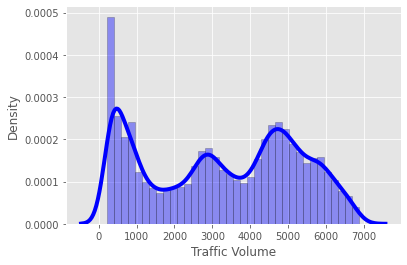

In [ ]:
plt.style.use('ggplot')
sns.distplot(metro_interstate['traffic_volume'], hist=True, kde=True, 
             bins=int(180/5), color = 'blue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, axlabel="Traffic Volume")

### Dataset description

In [ ]:
metro_interstate.info() #no missing values

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47905 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              47905 non-null  object 
 1   temp                 47905 non-null  float64
 2   rain_1h              47905 non-null  float64
 3   snow_1h              47905 non-null  float64
 4   clouds_all           47905 non-null  int64  
 5   weather_main         47905 non-null  object 
 6   weather_description  47905 non-null  object 
 7   date_time            47905 non-null  object 
 8   traffic_volume       47905 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.7+ MB


In [ ]:
metro_interstate.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


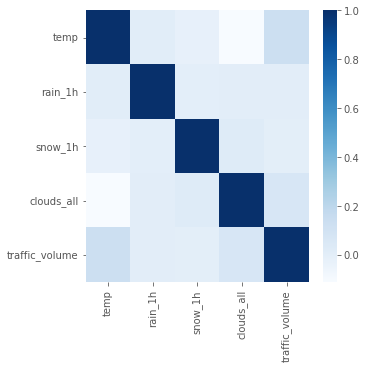

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))

sns.heatmap(metro_interstate.corr(), cmap="Blues", ax=ax) # no strong correlation between variables so we can use all variable in the model

### Feature selection and creation

In [ ]:
metro_interstate["date_time"] = pd.to_datetime(metro_interstate.date_time)

In [ ]:
metro_interstate["week_day"] = metro_interstate.date_time.dt.day_name()

In [ ]:
weekd_dict =  {
    'Monday': "work_day",
    'Tuesday': "work_day",
    'Wednesday': "work_day",
    'Thursday': "work_day",
    'Friday': "work_day",
    'Saturday': "weekend", 
    'Sunday': "weekend",
}

In [ ]:
metro_interstate.week_day = metro_interstate.week_day.replace(weekd_dict)

In [ ]:
#metro_interstate["month"] = metro_interstate.date_time.dt.month_name()

In [ ]:
groupped = metro_interstate.groupby(metro_interstate.date_time.dt.hour).mean()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0, 0.5, 'Traffic Volume Mean')

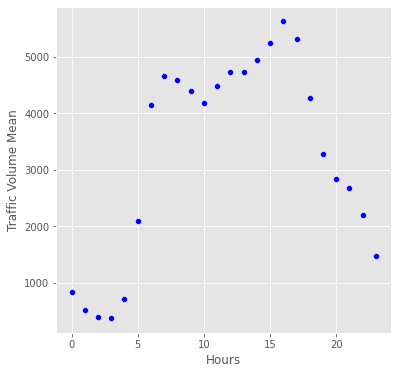

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
plot_2 = sns.scatterplot( groupped.index, groupped.traffic_volume, ax=ax, color = 'blue',  x_bins=1)
plot_2.set_xlabel("Hours")
plot_2.set_ylabel("Traffic Volume Mean")

In [ ]:
night = list(range(0,6))+list(range(22, 24))

In [ ]:
morning = list(range(6,11))

In [ ]:
noon = list(range(11, 14))

In [ ]:
afternoon = list(range(14, 19))

In [ ]:
evening = list(range(19, 22))

In [ ]:
metro_interstate.loc[metro_interstate.date_time.dt.hour.isin(night), "time_of_day"] = "night" 
metro_interstate.loc[metro_interstate.date_time.dt.hour.isin(morning), "time_of_day"] = "morning" 
metro_interstate.loc[metro_interstate.date_time.dt.hour.isin(noon), "time_of_day"] = "noon" 
metro_interstate.loc[metro_interstate.date_time.dt.hour.isin(evening), "time_of_day"] = "evening" 

In [ ]:
metro_interstate.drop("date_time", axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



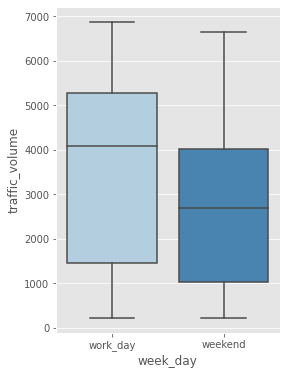

In [ ]:
fig, ax = plt.subplots(figsize=(4,6))
sns.boxplot( metro_interstate.week_day, metro_interstate.traffic_volume, palette="Blues", orient="v", ax=ax)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



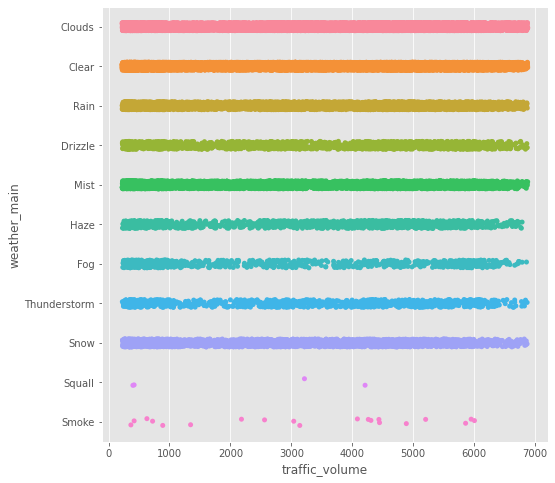

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
sns.stripplot(metro_interstate.traffic_volume, metro_interstate.weather_main,ax=ax)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



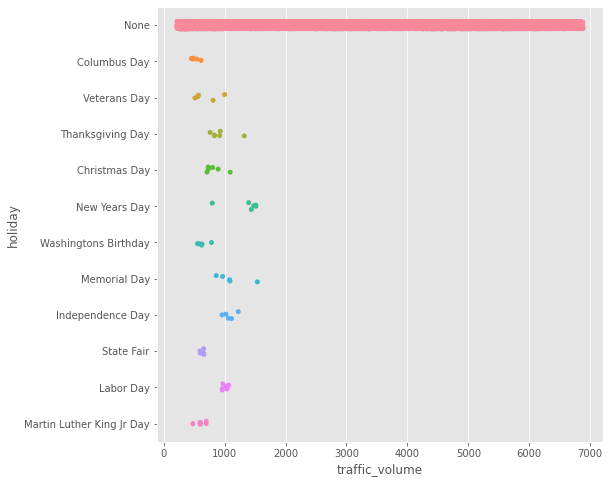

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
sns.stripplot(metro_interstate.traffic_volume, metro_interstate.holiday,ax=ax)

In [ ]:
metro_interstate.holiday = metro_interstate.holiday.where(metro_interstate.holiday=="None", "Holiday")

In [ ]:
#metro_interstate.weather_description.where(~metro_interstate.weather_main.isin(["Clouds", "Clear"]), metro_interstate.weather_main, inplace=True)

In [ ]:
df = metro_interstate.copy()
df.drop(["weather_description"], axis=1, inplace=True)

In [ ]:
df = pd.get_dummies(df)

In [ ]:
df.columns = df.columns.str.replace(" ", "_")

In [ ]:
df.shape

(47905, 24)

# Shuffle split of data

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, KFold

In [ ]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.33, random_state=RANDOM_SEED)

In [ ]:
df["target_cut"] = pd.qcut(df.traffic_volume, 8)

In [ ]:
for train_index, test_index in split.split(df, df.target_cut):
    df_train = df.drop("target_cut", axis=1).iloc[train_index, :].copy()
    df_test = df.drop("target_cut", axis=1).iloc[test_index, :].copy()

In [ ]:
model_features = list(df_train.columns)
model_features.remove("traffic_volume")

In [ ]:
model_features

['temp',
 'rain_1h',
 'snow_1h',
 'clouds_all',
 'holiday_Holiday',
 'holiday_None',
 'weather_main_Clear',
 'weather_main_Clouds',
 'weather_main_Drizzle',
 'weather_main_Fog',
 'weather_main_Haze',
 'weather_main_Mist',
 'weather_main_Rain',
 'weather_main_Smoke',
 'weather_main_Snow',
 'weather_main_Squall',
 'weather_main_Thunderstorm',
 'week_day_weekend',
 'week_day_work_day',
 'time_of_day_evening',
 'time_of_day_morning',
 'time_of_day_night',
 'time_of_day_noon']

In [ ]:
X_train = df_train[model_features]
X_test = df_test[model_features]
y_train = df_train.traffic_volume
y_test = df_test.traffic_volume
X = df[model_features]
Y = df.traffic_volume

# Creating & Applying the AutoML system on the datasets

In [ ]:
class MLAlgorithm:
    def __init__(self, algorithm_dict):
        self.generator = algorithm_dict['algorithm']
        # self.hyperparameter_ranges = algorithm_dict['hyperparameters']
        self.hyperparameter_ranges = list(algorithm_dict['hyperparameters'].items())
        self.algorithm_dict = algorithm_dict

        self.indicies = [0]*len(self.hyperparameter_ranges)
        self.hyperparameters = None
        self.algorithm = None

    def fit(self, X, Y):
        self.hyperparameters = {
            param:values[self.indicies[i]]
            for i, (param,values) in enumerate(self.hyperparameter_ranges)
        }
        # print(self.hyperparameters)

        self.algorithm = self.generator(**self.hyperparameters)
        self.algorithm.fit(X, Y)
    
    def predict(self, X):
        return self.algorithm.predict(X)

    def get_score(self, y_true, y_pred):
        sqrt = np.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
        return sqrt

    def get_neighbours(self):
        neighbours = []
        for i, j in enumerate(self.indicies):
            if j+1 == len(self.hyperparameter_ranges[i][1]):
                continue
            
            # len(self.indicies[i]):
            
            neighbour = MLAlgorithm(self.algorithm_dict)
            neighbour.indicies = self.indicies.copy()
            neighbour.indicies[i] = j+1
            neighbours.append(neighbour)

        return neighbours

class AutoML:
    """
        Implements the Auto ML system using a hill climbing algorithm.
    """
    def __init__(self, ml_algorithms, criteria=min):
        self.ml_algorithms = ml_algorithms
        self.criteria = criteria
        self.best_algorithm = None
        self.best_score = float('inf')
        self.best_hyperparameters = None
        self.scores = [float('inf')]*len(ml_algorithms)
    
    def fit(self, X_train, Y_train, X_test, Y_test):
        for i, algorithm in enumerate(self.ml_algorithms):
            algorithm.fit(X_train, Y_train)
            y_pred = algorithm.predict(X_test)
            score = algorithm.get_score(Y_test, y_pred)
            self.scores[i] = score

            if self.criteria(score, self.best_score) == score:
                self.best_score = score
                self.best_algorithm = algorithm

    def single_auto_ml_iteration(self, X_train, Y_train, X_test, Y_test):
        # get the initial scores
        self.fit(X_train, Y_train, X_test, Y_test)

        # create a copy list that will carry the new ml_algorithms
        new_solutions = self.ml_algorithms.copy()
        for i, algorithm in enumerate(self.ml_algorithms):
            # get the neighbours of the current solution (same algorithm, different hyperparameters)
            neighbours = algorithm.get_neighbours()

            # assume the initial algorithm is the best in the beginning
            best_score = self.scores[i]
            best_neighbour = new_solutions[i]

            # compute the score for every neighbour (RMSE)
            for neighbour in neighbours:
                neighbour.fit(X_train, Y_train)
                y_pred = neighbour.predict(X_test)
                score = neighbour.get_score(Y_test, y_pred)

                # keep track of the best neighbour
                if self.criteria(score, best_score) == score:
                    best_score = score
                    best_neighbour = neighbour

            # update the lists            
            self.scores[i] = best_score
            new_solutions[i] = best_neighbour

            if self.criteria(self.scores[i], self.best_score) == self.scores[i]:
                self.best_algorithm = best_neighbour
                self.best_score = self.scores[i]
                self.best_hyperparameters = best_neighbour.hyperparameters

        self.ml_algorithms = new_solutions
        
    def get_best_algorithm(self, iterations, X_train, Y_train, X_test, Y_test):
        for _ in range(iterations):
            self.single_auto_ml_iteration(X_train, Y_train, X_test, Y_test)
        
        return {'algorithm': self.best_algorithm,
                'score': self.best_score,
                'hyperparameters': self.best_hyperparameters}
    
    def print_summary(self):
        for i, algorithm in enumerate(self.ml_algorithms):
            print(f"{algorithm.algorithm}: score='{self.scores[i]}', hyperparameters='{algorithm.hyperparameters}'")

In [ ]:
algorithm1 = {
        'algorithm': RandomForestRegressor,
        'hyperparameters': {
            'n_estimators': [100, 150, 200, 300],
            'max_depth': np.arange(3, 15),
        }
    }

algorithm2 = {
        'algorithm': DecisionTreeRegressor,
        'hyperparameters': {
            'max_depth': np.arange(3, 15),
        }
    }

algorithm3 = {
        'algorithm': LinearRegression,
        'hyperparameters': {
            'normalize': [False, True],
            'fit_intercept': [True, False],
        }
    }

algorithms = [algorithm1, algorithm2, algorithm3]
algorithms = [MLAlgorithm(algo) for algo in algorithms]

automl_system = AutoML(algorithms)


print(f"Testing my system against dataset METRO_INTERSTATE")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

iterations = 5
best_algorithm = automl_system.get_best_algorithm(iterations, 
                                                    X_train, 
                                                    y_train, 
                                                    X_test, 
                                                    y_test)
    
print("System summary:-")
automl_system.print_summary()

print(f"The best algorithm for dataset METRO_INTERSTATE:", end=" ")
print(best_algorithm['algorithm'].algorithm)

print("The best hyperparameters for this algorithm:", end=" ")
print(best_algorithm['hyperparameters'])

print("The RMSE score of this algorithm:", end=" ")
print(best_algorithm['score'])

train_predictions = best_algorithm['algorithm'].predict(X_train)
print("Train R2 score:", sklearn.metrics.r2_score(y_train, train_predictions))

test_predictions = best_algorithm['algorithm'].predict(X_test)
print("Test R2 score:", sklearn.metrics.r2_score(y_test, test_predictions))
print("-"*40)

Testing my system against dataset METRO_INTERSTATE
X_train shape: (32096, 23)
y_train shape: (32096,)
X_test shape: (15809, 23)
y_test shape: (15809,)
System summary:-
RandomForestRegressor(max_depth=8): score='790.0978777451933', hyperparameters='{'n_estimators': 100, 'max_depth': 8}'
DecisionTreeRegressor(max_depth=7): score='802.7816360581845', hyperparameters='{'max_depth': 7}'
LinearRegression(fit_intercept=False, normalize=True): score='2306.348239043954', hyperparameters='{'normalize': True, 'fit_intercept': False}'
The best algorithm for dataset METRO_INTERSTATE: RandomForestRegressor(max_depth=8)
The best hyperparameters for this algorithm: {'n_estimators': 100, 'max_depth': 8}
The RMSE score of this algorithm: 790.0978777451933
Train R2 score: 0.842736856261093
Test R2 score: 0.839883736692401
----------------------------------------


# Comparing our system to sklearn-automl system

In [ ]:
print(f"Testing auto-sklearn system against dataset METRO_INTERSTATE")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print()

automl = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task=180,
    per_run_time_limit=40,
    tmp_folder='telmp',
    )

automl.fit(X_train, y_train)

print("Leaderboard:")
print(automl.leaderboard())

train_predictions = automl.predict(X_train)
print("Train R2 score:", sklearn.metrics.r2_score(y_train, train_predictions))

test_predictions = automl.predict(X_test)
print("Test R2 score:", sklearn.metrics.r2_score(y_test, test_predictions))

Testing auto-sklearn system against dataset METRO_INTERSTATE
X_train shape: (32096, 23)
y_train shape: (32096,)
X_test shape: (15809, 23)
y_test shape: (15809,)



FileExistsError: ignored

# Comparing our system to TPOT auto ml system

In [ ]:
# I've lowered the population size and the generation size to make 
# the notebook run in a resonable time
# increasing the numbers would yield a far better accuracy for sure

print(f"Testing TPOT system against dataset METRO_INTERSTATE")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print()
tpot = TPOTRegressor(generations=2, 
                     population_size=5, 
                     verbosity=2, 
                     random_state=42)
tpot.fit(X_train, y_train)

print("MSE:",tpot.score(X_test, y_test))
print("RMSE:",np.sqrt(tpot.score(X_test, y_test)))

train_predictions = tpot.predict(X_train)
print("Train R2 score:", sklearn.metrics.r2_score(y_train, train_predictions))

test_predictions = tpot.predict(X_test)
print("Test R2 score:", sklearn.metrics.r2_score(y_test, test_predictions))

Testing TPOT system against dataset METRO_INTERSTATE
X_train shape: (32096, 23)
y_train shape: (32096,)
X_test shape: (15809, 23)
y_test shape: (15809,)



Optimization Progress:   0%|          | 0/15 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -639876.4089885443

Generation 2 - Current best internal CV score: -639779.9658581874

Best pipeline: RandomForestRegressor(input_matrix, bootstrap=True, max_features=0.4, min_samples_leaf=16, min_samples_split=14, n_estimators=100)
MSE: -620122.4655878935


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in sqrt



RMSE: nan
Train R2 score: 0.8488093985630522
Test R2 score: 0.8409436101720813
